# Ordinary Kriging of *meuse* dataset
## Comparison to `gstat` package from `R`

Ordinary Kriging is a basic operation in `Pyinterpolate` package and results obtained by this method are compared to the methods of `gstat` package written in `R` language. This notebook is structured as follows:

1. R code for Kriging interpolation.
2. Import of Python packages.
3. Semivariogram modeling: the experimental semivariogram.
4. Semivariogram modeling: the fit of theoretical model.
5. Kriging: sanity check - unbiasedness.
6. Kriging: interpolation.
7. Comparison of interpolated results: statistics.
8. Comparison of interpolated results: maps.

*meuse* dataset is a part of `sp` package which is presented in:

> Pebesma, Edzer. (2009). The meuse data set: a tutorial for the gstat R package. URL: https://cran.r-project.org/web/packages/gstat/vignettes/gstat.pdf

### 1. `R` code for Kriging interpolation

```r

library(sp)
library(gstat)
data(meuse)
data("meuse.grid")

coordinates(meuse) <- ~ x + y
coordinates(meuse.grid) <- ~ x + y

lzn.vgm <- variogram(log(zinc)~1, meuse)

# vgm(psill, model, range, nugget)
# where:
# psill - mean of the last five values of experimental semivariances
# nugget - mean of the first three values of experimental semivariances
# range - 1/3 of the max distance

lzn.fit <- fit.variogram(lzn.vgm, model=vgm(NA, "Sph", NA, NA))

# plot(lzn.vgm, lzn.fit)

lzn.kriged <- krige(log(zinc) ~ 1, meuse, meuse.grid, model=lzn.fit)
```

### 2. Import `python` packages

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

from pyinterpolate.variogram import build_experimental_variogram # experimental semivariogram
from pyinterpolate.variogram import TheoreticalVariogram  # theoretical models
from pyinterpolate.kriging import kriging
from scipy.stats import pearsonr
from shapely.geometry import Point

import matplotlib.pyplot as plt

In [2]:
# Read data

df = pd.read_csv('meuse.csv')

# Get only x, y and zinc concentration columns

df = df[['x', 'y', 'zinc']]

# Transform zinc column

df['zinc'] = np.log(df['zinc'])

# Take a look into dataset

df.head()

,x,y,zinc
0,181072,333611,6.929517
1,181025,333558,7.039660
2,181165,333537,6.461468
3,181298,333484,5.549076
4,181307,333330,5.594711


### 3. Calculate and load experimental semivariogram 

In [3]:
# Experimental Semivariogram from gstat

gstat_variogram = pd.read_csv('variogram_gstat.csv')

In [4]:
gstat_variogram = gstat_variogram[['dist', 'gamma', 'np']].values

In [5]:
# Experimental Semivariogram from pyinterpolate

step = 100
max_r = gstat_variogram[-1][0]

variogram = build_experimental_variogram(
    input_array=df.values,
    step_size=step,
    max_range=max_r
)

pyint_variogram = variogram.experimental_semivariance_array

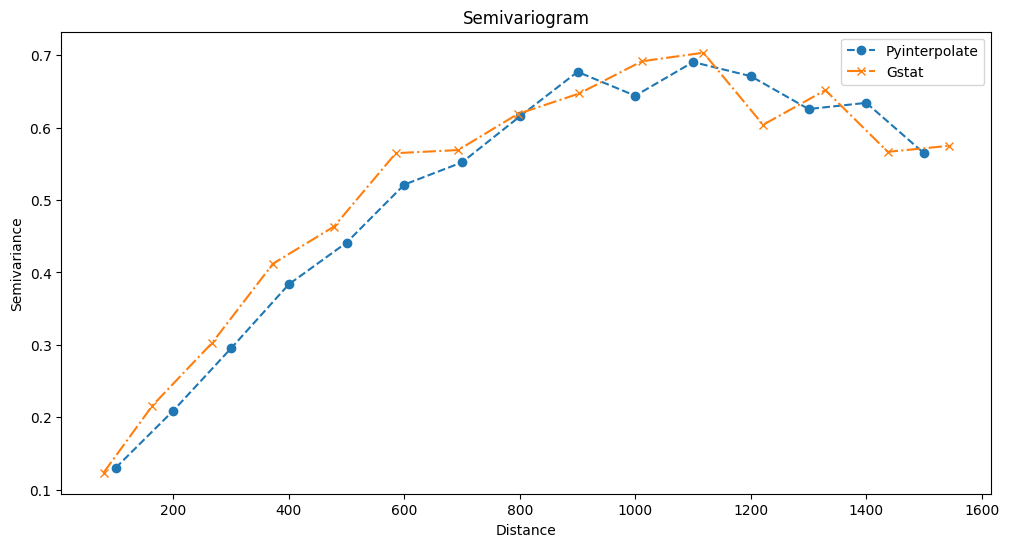

In [6]:
# Plot experimental semivariograms

plt.figure(figsize=(12, 6))
plt.plot(pyint_variogram[:, 0], pyint_variogram[:, 1], '--o')
plt.plot(gstat_variogram[:, 0], gstat_variogram[:, 1], '-.x')
plt.title('Semivariogram')
plt.xlabel('Distance')
plt.ylabel('Semivariance')
plt.legend(['Pyinterpolate', 'Gstat'])
plt.show()

### 4. Semivariogram modeling: fit of theoretical models

In [7]:
gstat_params = pd.read_csv('theoretical_model_gstat.csv')
gstat_params

,Unnamed: 0,model,psill,range,kappa,ang1,ang2,ang3,anis1,anis2
0,1,Nug,0.050660,0.000000,0.0,0,0,0,1,1
1,2,Sph,0.590605,897.001083,0.5,0,0,0,1,1


In [8]:
# Based on the gstat

theo_gstat = TheoreticalVariogram()
theo_gstat.experimental_array = gstat_variogram
theo_gstat.fit(experimental_variogram=gstat_variogram,
               model_type='spherical',
               sill=gstat_params[gstat_params['model'] == 'Sph']['psill'].values[0],
               rang=gstat_params[gstat_params['model'] == 'Sph']['range'].values[0])



(array([[7.92924375e+01, 7.81078312e-02],
        [1.63973666e+02, 1.60141873e-01],
        [2.67364828e+02, 2.56238366e-01],
        [3.72735422e+02, 3.46937700e-01],
        [4.78476695e+02, 4.27739384e-01],
        [5.85340581e+02, 4.96044808e-01],
        [6.93145256e+02, 5.48315263e-01],
        [7.96183649e+02, 5.79833252e-01],
        [9.03146498e+02, 5.90605108e-01],
        [1.01129177e+03, 5.90605108e-01],
        [1.11786235e+03, 5.90605108e-01],
        [1.22132810e+03, 5.90605108e-01],
        [1.32916407e+03, 5.90605108e-01],
        [1.43725620e+03, 5.90605108e-01],
        [1.54320248e+03, 5.90605108e-01]]),
 {'rmse': 0.05796101808949019,
  'bias': 0.04545453712272922,
  'mae': 0.050768630821049876,
  'smape': 6.700003261680393})

In [9]:
# Based on the pyinterpolate

theo_pyint = TheoreticalVariogram()
opt_pyint = theo_pyint.autofit(pyint_variogram)
print(f'Optimal model is {opt_pyint}')

Optimal model is {'model_type': 'circular', 'nugget': 0, 'sill': 0.6081188739940903, 'rang': 750.0, 'fitted_model': array([[1.00000000e+02, 1.02930757e-01],
       [2.00000000e+02, 2.04001033e-01],
       [3.00000000e+02, 3.01242889e-01],
       [4.00000000e+02, 3.92438776e-01],
       [5.00000000e+02, 4.74878790e-01],
       [6.00000000e+02, 5.44820973e-01],
       [7.00000000e+02, 5.95679624e-01],
       [8.00000000e+02, 6.08118874e-01],
       [9.00000000e+02, 6.08118874e-01],
       [1.00000000e+03, 6.08118874e-01],
       [1.10000000e+03, 6.08118874e-01],
       [1.20000000e+03, 6.08118874e-01],
       [1.30000000e+03, 6.08118874e-01],
       [1.40000000e+03, 6.08118874e-01],
       [1.50000000e+03, 6.08118874e-01]]), 'rmse': 0.04015736751063702, 'bias': nan, 'mae': nan, 'smape': nan}


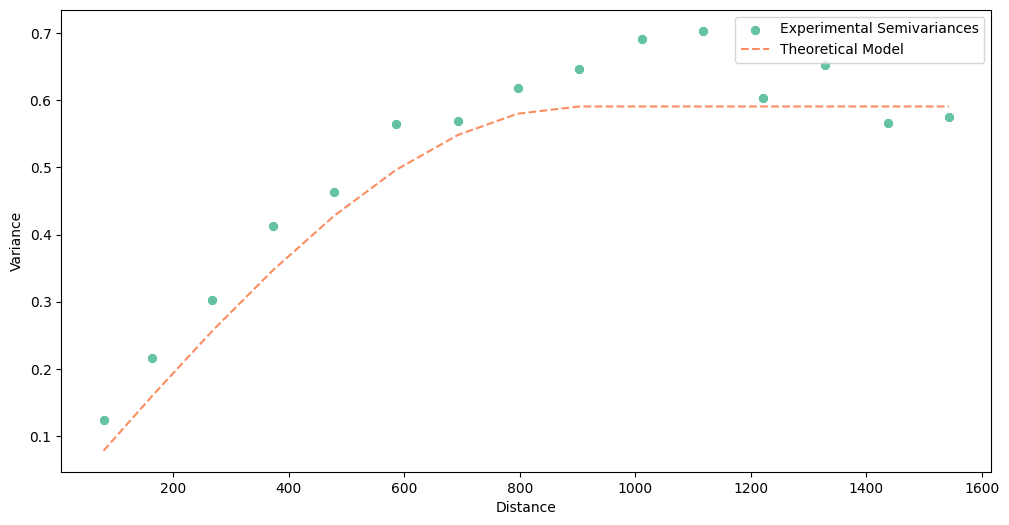

In [10]:
# Show gstat semivariogram

theo_gstat.plot()

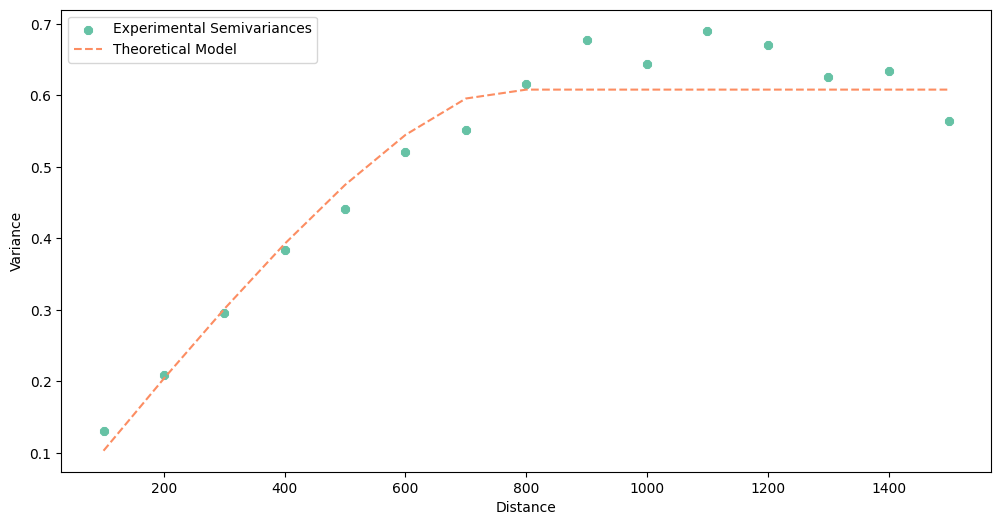

In [11]:
# Show pyinterpolate semivariogram

theo_pyint.plot()

### 5. Kriging: sanity check - unbiasedness

Kriging is an unbiased estimator which means that interpolated values at known locations are the same as measurements. In this step we check this property with random sample from measurements.

In [12]:
unknown = df.sample().values[0]
unknown_val = unknown[-1]
unknown_loc = unknown[:-1]
nn = 32

In [13]:
ok_pred = kriging(observations=df.values,
                  theoretical_model=theo_pyint,
                  points=[unknown_loc],
                  no_neighbors=nn)

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 926.10it/s]


In [14]:
ok_pred[0]

array([6.65672652e+00, 0.00000000e+00, 1.79852000e+05, 3.30801000e+05])

In [15]:
np.equal(ok_pred[0][0], unknown_val)

True

### 6. Kriging: interpolation

In [16]:
# Read point grid

data = pd.read_csv('meuse_grid.csv')
data = data[['x', 'y']].values

In [17]:
predictions_gstat_model = kriging(observations=df.values,
                                  theoretical_model=theo_gstat,
                                  points=data,
                                  no_neighbors=nn)

predictions_pyint_model = kriging(observations=df.values,
                                  theoretical_model=theo_pyint,
                                  points=data,
                                  no_neighbors=nn)

# Merge two outputs
predicted_rows = []

for idx, predicted in enumerate(predictions_gstat_model):
    cx = predicted[2]
    cy = predicted[3]
    gstat_pred = predicted[0]
    gstat_err = predicted[1]
    
    pyint_row = predictions_pyint_model[idx]
    
    # Check coords
    if pyint_row[2] == cx and pyint_row[3] == cy:
        pyint_pred = pyint_row[0]
        pyint_err = pyint_row[1]
        
        prepared_row = [cx, cy, gstat_pred, gstat_err, pyint_pred, pyint_err]
        predicted_rows.append(prepared_row)
        
pcols = ['x', 'y', 'pyint.gstat.pred', 'pyint.gstat.err', 'pyint.pred', 'pyint.err']
predictions = pd.DataFrame(predicted_rows, columns=pcols)

100%|█████████████████████████████████████| 3103/3103 [00:02<00:00, 1356.48it/s]


In [18]:
predictions.head()

,x,y,pyint.gstat.pred,pyint.gstat.err,pyint.pred,pyint.err
0,181180.0,333740.0,6.561328,0.269081,6.574310,0.285739
1,181140.0,333700.0,6.680019,0.185332,6.700040,0.198016
2,181180.0,333700.0,6.558463,0.209753,6.575046,0.224042
3,181220.0,333700.0,6.394609,0.237157,6.440834,0.254056
4,181100.0,333660.0,6.808313,0.101161,6.828536,0.106706


### 7. Comparison of interpolated results: statistics

In [19]:
# Read predictions from R

rpred = pd.read_csv('kriged.csv')
rpred.drop('Unnamed: 0', inplace=True, axis=1)

In [20]:
rpred.head()

,x,y,var1.pred,var1.var,optional
0,181180,333740,6.499618,0.319808,True
1,181140,333700,6.622352,0.252020,True
2,181180,333700,6.505162,0.272985,True
3,181220,333700,6.387586,0.295529,True
4,181100,333660,6.764491,0.177940,True


In [21]:
# Merge dataframes

merged = rpred.merge(predictions, on=['x', 'y'])
merged.dropna(inplace=True)

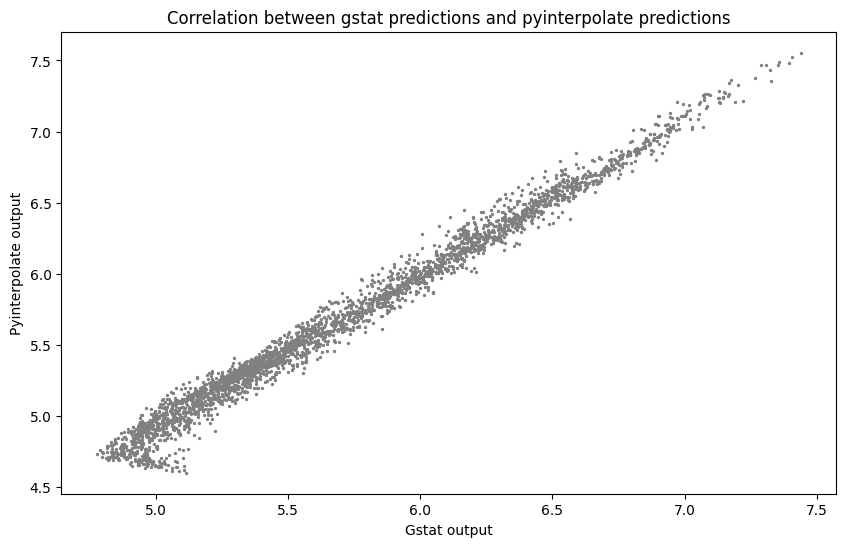

In [22]:
# Show scatterplots of predicted by pyinterpolate and gstat (from R)

plt.figure(figsize=(10, 6))
plt.scatter(merged['var1.pred'], merged['pyint.pred'], c='gray', s=2)
plt.title('Correlation between gstat predictions and pyinterpolate predictions')
plt.xlabel('Gstat output')
plt.ylabel('Pyinterpolate output')
# plt.savefig('gstatxpyint.png', dpi=300, bbox_inches='tight')
plt.show()

In [23]:
# Pearson corr coefficient

pearsonr(merged['var1.pred'], merged['pyint.pred'])

PearsonRResult(statistic=0.9925346608035537, pvalue=0.0)

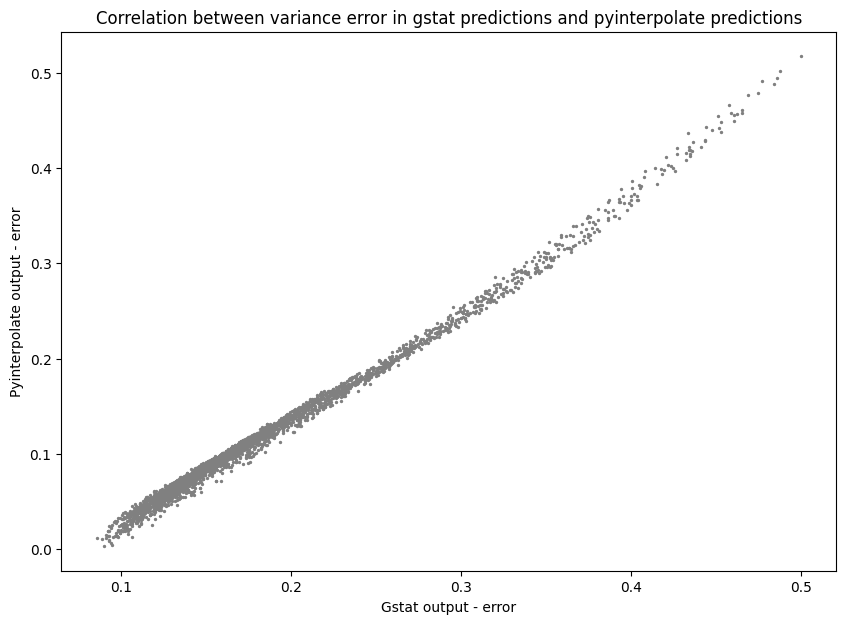

In [24]:
# Show scatterplots of predicted error maps by pyinterpolate and gstat (from R)

plt.figure(figsize=(10, 7))
plt.scatter(merged['var1.var'], merged['pyint.err'], c='gray', s=2)
plt.title('Correlation between variance error in gstat predictions and pyinterpolate predictions')
plt.xlabel('Gstat output - error')
plt.ylabel('Pyinterpolate output - error')
# plt.savefig('gstaterrxpyinterr.png', dpi=300, bbox_inches='tight')
plt.show()

In [25]:
# Pearson corr coefficient

pearsonr(merged['var1.var'], merged['pyint.err'])

PearsonRResult(statistic=0.9964737140966643, pvalue=0.0)

### 8. Comparison of interpolated results: maps

In [26]:
# Transform data into GeoDataFrame

def df_to_geo(dataframe, lon_col='longitude', lat_col='latitude'):
    """Function transform longitude and latitude coordinates into GeoSeries.
    
    INPUT:
    
    :param dataframe: DataFrame to be transformed,
    :param lon_col: (str) longitude column name, default is 'longitude',
    :param lat_col: (str) latitude column name, default is 'latitude'.
    
    OUTPUT:
    
    :return: (GeoPandas GeoDataFrame)
    """

    # Transform lon / lat to points
    geometry = dataframe.apply(lambda x: Point([x[lon_col], x[lat_col]]), axis=1)
    geometry.name = 'geometry'
    
    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(dataframe)
    gdf = gdf.join(geometry)
    
    return gdf

In [27]:
geo_df = df_to_geo(merged, 'x', 'y')

/home/szymon/miniconda3/envs/p310/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [28]:
geo_df.head()

,x,y,var1.pred,var1.var,optional,pyint.gstat.pred,pyint.gstat.err,pyint.pred,pyint.err,geometry
0,181180,333740,6.499618,0.319808,True,6.561328,0.269081,6.574310,0.285739,POINT (181180.000 333740.000)
1,181140,333700,6.622352,0.252020,True,6.680019,0.185332,6.700040,0.198016,POINT (181140.000 333700.000)
2,181180,333700,6.505162,0.272985,True,6.558463,0.209753,6.575046,0.224042,POINT (181180.000 333700.000)
3,181220,333700,6.387586,0.295529,True,6.394609,0.237157,6.440834,0.254056,POINT (181220.000 333700.000)
4,181100,333660,6.764491,0.177940,True,6.808313,0.101161,6.828536,0.106706,POINT (181100.000 333660.000)


In [29]:
max(geo_df["var1.pred"].max(), geo_df["pyint.pred"].max())
min(geo_df["var1.pred"].min(), geo_df["pyint.pred"].min())

4.6027651892920645

<AxesSubplot:>

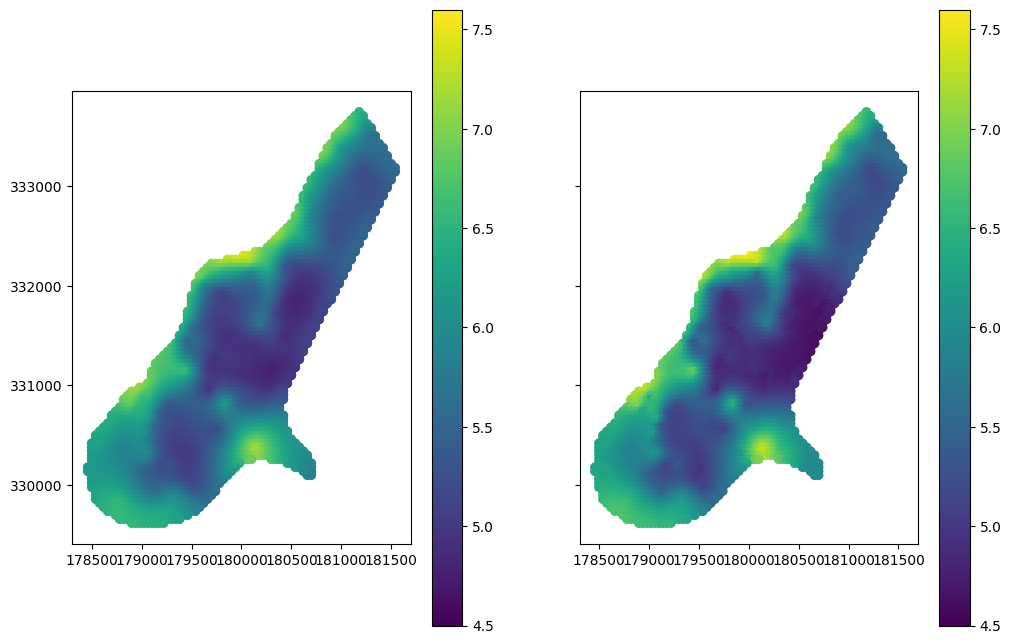

In [30]:
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(12, 8))
geo_df.plot(ax=axes[0], column='var1.pred', legend=True, vmin=4.5, vmax=7.6)
geo_df.plot(ax=axes[1], column='pyint.pred', legend=True, vmin=4.5, vmax=7.6)
# plt.savefig('predicted_comparison.png', dpi=300, bbox_inches='tight')

<AxesSubplot:>

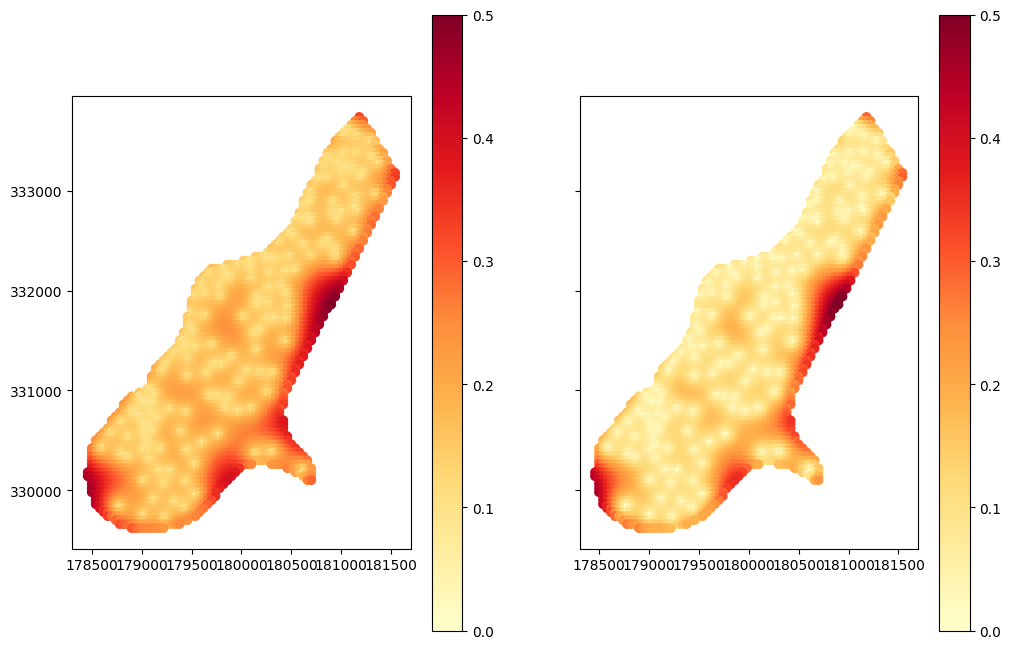

In [31]:
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(12, 8))
geo_df.plot(ax=axes[0], column='var1.var', cmap='YlOrRd', legend=True, vmin=0, vmax=0.5)
geo_df.plot(ax=axes[1], column='pyint.err', cmap='YlOrRd', legend=True, vmin=0, vmax=0.5)
# plt.savefig('errors_comparison.png', dpi=300, bbox_inches='tight')÷

In [32]:
geo_df['err_diff'] = geo_df['var1.var'] - geo_df['pyint.err']

In [33]:
geo_df['err_diff'].describe()

count    3103.000000
mean        0.063169
std         0.010742
min        -0.017128
25%         0.060387
50%         0.063693
75%         0.068097
max         0.093661
Name: err_diff, dtype: float64

<AxesSubplot:>

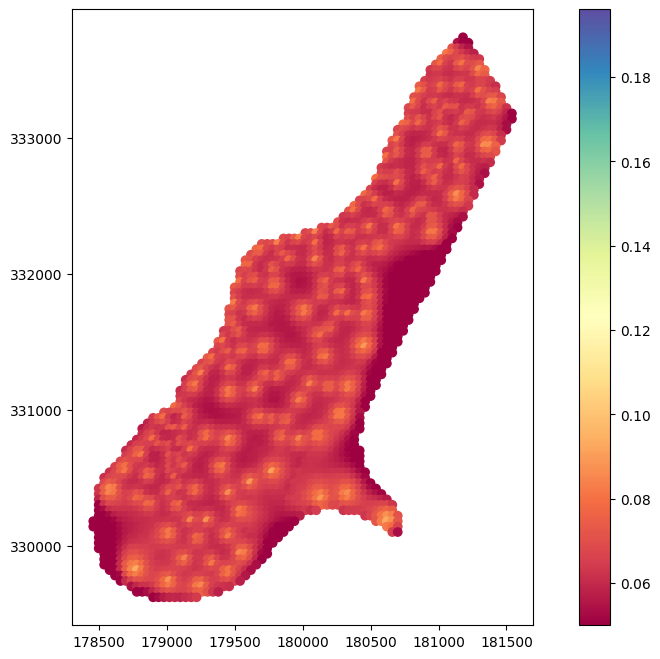

In [34]:
fig, axes = plt.subplots(ncols=1, figsize=(12, 8))
geo_df.plot(ax=axes, column='err_diff', cmap='Spectral', legend=True, vmin=0.05, vmax=0.196084)
# plt.savefig('errors_difference.png', dpi=300, bbox_inches='tight')

---